# Mask2Face
This notebook will guide you through all the steps described in this article to build and train your ML model for removing the face mask of the person's face.

In [1]:
# this notebook is built on conda env tf_test_1
# Clone mask2face and enter the mask2face folder 
%cd C:\Users\daryl\Development\imagine-ai\strv-ml-mask2face
# # Install other depencencies
# # fix albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible
# !pip install imgaug==0.2.6
# !pip install mtcnn
# !pip install matplotlib
# !pip install tqdm
# !pip install cmake
# !pip install sklearn
# !pip install ipywidgets
# #!conda install -c conda-forge dlib
# #!pip install https://pypi.python.org/packages/da/06/bd3e241c4eb0a662914b3b4875fc52dd176a9db0d4a2c915ac2ad8800e9e/dlib-19.7.0-cp36-cp36m-win_amd64.whl#md5=b7330a5b2d46420343fbed5df69e6a3f
# !pip install -r requirements.txt
# print('end of installs')

C:\Users\daryl\Development\imagine-ai\strv-ml-mask2face


In [2]:
# Necessary imports
import os
import tarfile
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import download_data
from utils.configuration import Configuration
from utils.data_generator import DataGenerator
from utils.architectures import UNet
from utils.model import Mask2FaceModel
from multiprocessing import Process

In [3]:
tf.__version__

'2.7.0'

In [4]:
# setup HW

# is GPU available
gpu_physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_physical_devices) > 0:
    tf.config.experimental.set_memory_growth(gpu_physical_devices[0], True)

# check HW availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPUs Available:  1


In [5]:
!nvidia-smi

Sun Jan 23 01:01:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.33       Driver Version: 461.33       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   46C    P0    26W /  N/A |   1087MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1) Preconditions
First we need a dataset of human faces.

In [6]:
# Check if dataset is already downloaded or needs to be downloaded.
configuration = Configuration()
dataset_path = configuration.get('input_images_path')
if os.path.isdir(dataset_path):
    print('Dataset already downloaded')
else:
    print('Downloading dataset')
    !mkdir 'data'
    dataset_archive_path = os.path.join('data', 'lfw-deepfunneled.tgz')
    download_data(configuration.get('dataset_archive_download_url'), dataset_archive_path)
    print('Extracting dataset')
    tar = tarfile.open(dataset_archive_path, 'r:gz')
    tar.extractall('data')
    tar.close()
    print('Done')

Dataset already downloaded


## 2) Data generation
Next step is to generate data for neural network training. We need input images (person with a face mask) and corresponding output image (the same image as input but without the face mask). We already have output images in downloaded dataset. Input images will be created by adding mask on the faces with a help from [MaskTheFace GitHub](https://github.com/aqeelanwar/MaskTheFace) project.

In [7]:
# setup the pipeline and generate data

dg = DataGenerator(configuration)

train_folder = configuration.get('train_data_path')
test_folder = configuration.get('test_data_path')

# if os.path.exists(train_folder) and os.path.exists(test_folder):
#     print('Testing and training data already generated')
# else:
dg.generate_images_multicore(test_image_count=1, train_image_count=12500, core="2")
# dg.generate_images_multicore(test_image_count=1, train_image_count=1, core="2")
#     dg.generate_images()




# print('Here are few examples of generated data.')
# n_examples = 5
# inputs, outputs = dg.get_dataset_examples(n_examples)
# f, axarr = plt.subplots(2, n_examples, figsize=(20, 10))
# for i in range(len(inputs)):
#     axarr[1, i].imshow(mpimg.imread(inputs[i]))
#     axarr[1, i].axis('off')
#     axarr[0, i].imshow(mpimg.imread(outputs[i]))
#     axarr[0, i].axis('off')

Generating testing data


  0%|          | 0/1 [00:00<?, ?it/s]

Generating training data


  0%|          | 0/12500 [00:00<?, ?it/s]

No keypoints detected on image
No keypoints detected on image


C:\Users\daryl\Development\imagine-ai\strv-ml-mask2face\mask_utils\fit_ellipse.py:42: RuntimeWarning: invalid value encountered in sqrt
  res1 = np.sqrt(up / down1)


No keypoints detected on image
No keypoints detected on image


C:\Users\daryl\Development\imagine-ai\strv-ml-mask2face\mask_utils\fit_ellipse.py:43: RuntimeWarning: invalid value encountered in sqrt
  res2 = np.sqrt(up / down2)


## 3) Model training
Now we have all the data, and we can initiate model and start training.

In [7]:
# Feel free to experiment with the number of filters, their sizes or any other parameters
filters = (64, 128, 128, 256, 256, 512)
kernels = (7, 7, 7, 3, 3, 3)
input_image_size = (256, 256, 3)
architecture = UNet.RESNET
training_epochs = 100
batch_size = 9
#stable settings on colab:
#reduced config data to 2000 train, 200 test due to cpu RAM OOM (not VRAM)
#train 2000
#test 200
#batch size 30
#epochs 15, colab forcefully ends it well before 20 are reached

#stable settings on local:
#train 60000
#test 4900
#batch size 9
#epochs 100 (stops after 24 epochs==35 hours)


In [8]:
#uncomment to train own model
# Create instance of model and start training
model = Mask2FaceModel.build_model(architecture=architecture, input_size=input_image_size, filters=filters,
                                   kernels=kernels, configuration=configuration)
model.train(epochs=training_epochs, batch_size=batch_size, loss_function='ssim_l1_loss')

# #If you already have pretrained model you can uncomment next line and load it instead of training new one
# model = Mask2FaceModel.load_model('models/model_epochs-60_batch-9_loss-ssim_l1_loss_20211213_17_21_00.h5') 

Using UNet Resnet model
Loading training data from data/train with limit of 60000 images
Loading testing data from data/test with limit of 4900 images
545/545 [==============================] - 134s 214ms/step - loss: 0.6780 - acc: 0.1334 - recall: 0.6075 - precision: 0.9927
- TEST -> LOSS:     0.6780, ACC:     0.1334, RECALL:     0.6075, PRECISION:     0.9927
Epoch 1/100
5232/5232 [==============================] - ETA: 0s - loss: 0.0931 - acc: 0.9115 - recall: 0.4108 - precision: 1.0000

C:\Users\daryl\anaconda3\envs\tf_test_1\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


5232/5232 [==============================] - 5346s 1s/step - loss: 0.0931 - acc: 0.9115 - recall: 0.4108 - precision: 1.0000 - val_loss: 0.0629 - val_acc: 0.9195 - val_recall: 0.3764 - val_precision: 1.0000
Epoch 2/100
5232/5232 [==============================] - 5247s 999ms/step - loss: 0.0606 - acc: 0.9285 - recall: 0.3995 - precision: 1.0000 - val_loss: 0.0544 - val_acc: 0.9508 - val_recall: 0.4137 - val_precision: 1.0000
Epoch 3/100
5232/5232 [==============================] - 5240s 997ms/step - loss: 0.0543 - acc: 0.9343 - recall: 0.3983 - precision: 1.0000 - val_loss: 0.0540 - val_acc: 0.9402 - val_recall: 0.4114 - val_precision: 1.0000
Epoch 4/100
5232/5232 [==============================] - 5243s 998ms/step - loss: 0.0515 - acc: 0.9391 - recall: 0.3981 - precision: 1.0000 - val_loss: 0.0476 - val_acc: 0.9240 - val_recall: 0.4017 - val_precision: 1.0000
Epoch 5/100
5232/5232 [==============================] - 5250s 999ms/step - loss: 0.0495 - acc: 0.9431 - recall: 0.3982 - preci

## 4) Results
Our model is trained, and we can look at it's performance

data/test\inputs\004855.png
<class 'str'>
(234, 256)
data/test\inputs\002996.png
<class 'str'>
(249, 256)
data/test\inputs\003060.png
<class 'str'>
(235, 256)
data/test\inputs\000596.png
<class 'str'>
(245, 256)
data/test\inputs\004774.png
<class 'str'>
(235, 256)
data/test\inputs\000899.png
<class 'str'>
(256, 256)
data/test\inputs\003933.png
<class 'str'>
(255, 256)
data/test\inputs\000728.png
<class 'str'>
(236, 256)
data/test\inputs\001067.png
<class 'str'>
(225, 256)
data/test\inputs\001375.png
<class 'str'>
(229, 256)
data/test\inputs\004689.png
<class 'str'>
(230, 254)
data/test\inputs\000042.png
<class 'str'>
(256, 256)
data/test\inputs\003157.png
<class 'str'>
(250, 256)
data/test\inputs\004844.png
<class 'str'>
(239, 256)
data/test\inputs\001843.png
<class 'str'>
(249, 256)
data/test\inputs\003821.png
<class 'str'>
(239, 256)
data/test\inputs\000854.png
<class 'str'>
(248, 256)
data/test\inputs\004348.png
<class 'str'>
No keypoints detected on image
(256, 256)
data/test\input

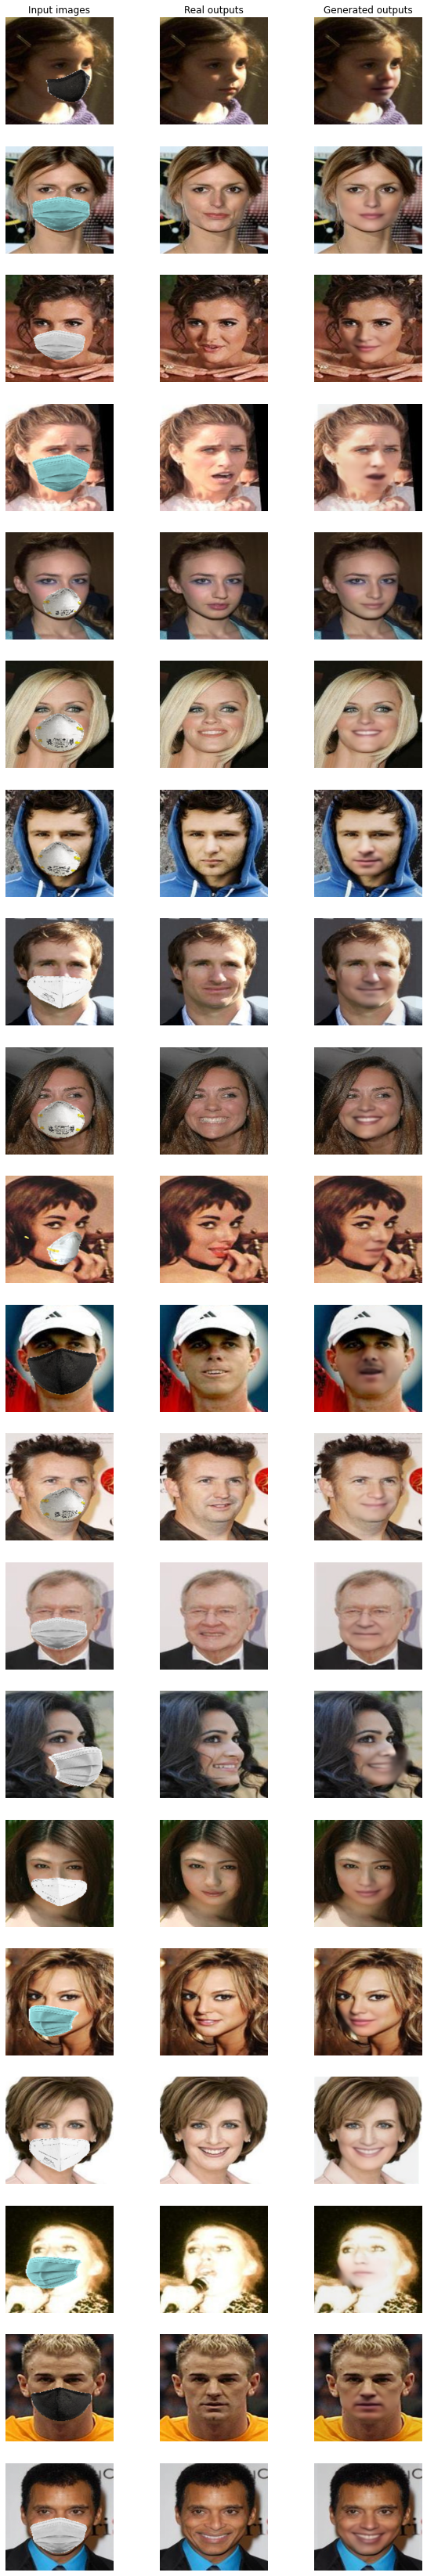

In [18]:
# Let's see the results on a random testing image unseen by the model before.
# Run this cell multiple times to see different results
n_examples = 20
input_imgs, true_output_imgs = dg.get_dataset_examples(n_examples, test_dataset=True)
f, axarr = plt.subplots(n_examples, 3, figsize=(10, n_examples * 3))
for i, img in enumerate(input_imgs):
    print(img)
    print(type(img))
    generated_output = model.predict(img)
    axarr[i, 0].imshow(mpimg.imread(input_imgs[i]))
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(mpimg.imread(true_output_imgs[i]))
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(generated_output)
    axarr[i, 2].axis('off')

axarr[0, 0].set_title('Input images')
axarr[0, 1].set_title('Real outputs')
axarr[0, 2].set_title('Generated outputs')
print('Outputs generated on previously unseen data.')

In [16]:
print('total runtime: '+str(24*5232/3600))

total runtime: 34.88


(231, 256)


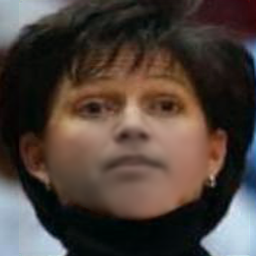

In [25]:
from PIL import Image
from io import BytesIO

input_shape = (256, 256)
image_path = 'test.png'

def read_image(image_path):
    loaded_image = tf.keras.preprocessing.image.load_img(image_path)
    return loaded_image

def preprocess(loaded_image, image_path):
    resized_image = loaded_image.resize(input_shape)
    resized_image.save(image_path)
    return

def predict_result(image_path: image_path, model):
    result = model.predict(image_path)
    result.save('output'+image_path)
    return result

preprocess(read_image(image_path), image_path)

predict_result(image_path, model)


In [41]:
model.compute_output_shape(input_shape=(None, 256,256,3))
model.save('models/')

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
C:\Users\daryl\anaconda3\envs\tf_test_1\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\daryl\anaconda3\envs\tf_test_1\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [42]:
my_model = tf.keras.models.load_model('models/')
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()
open("models/converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\daryl\AppData\Local\Temp\tmpsddfys0b\assets


INFO:tensorflow:Assets written to: C:\Users\daryl\AppData\Local\Temp\tmpsddfys0b\assets


214375888

In [2]:
pip freeze

absl-py==1.0.0
anyio==3.4.0
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
astunparse==1.6.3
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
attrs @ file:///tmp/build/80754af9/attrs_1620827162558/work
Babel @ file:///tmp/build/80754af9/babel_1620871417480/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
bleach==4.1.0
brotlipy==0.7.0
cachetools==4.2.4
certifi==2021.10.8
cffi @ file:///C:/ci/cffi_1636542074879/work
charset-normalizer==2.0.9
cmake==3.22.1
colorama @ file:///tmp/build/80754af9/colorama_1607707115595/work
cryptography @ file:///C:/ci/cryptography_1635348572149/work
cycler==0.11.0
debugpy @ file:///C:/ci/debugpy_1637073815078/work
decorator @ file:///tmp/build/80754af9/decorator_1632776554403/work
defusedxml @ file:///tmp/build/80754af9/defusedxml_1615228127516/work
dlib @ file:///D:/bld/dlib_1617441823598/work
dotmap==1.3.23
entrypoints==0.3
flatbuffers==2.0
fonttools==4.28.3
gast==0.4.0
google-auth==2.3.3
google-auth-